In [116]:
import pandas as pd
from jqdata import finance
import pylab as pl
from datetime import datetime, timedelta
from sqlalchemy import extract
import seaborn as sns

### 初始参数

In [103]:
start_date = datetime.now()-timedelta(days=365*3)
end_date = datetime.now()
code = '161005'
index_code = '163407'

### 基本信息

In [3]:
df = finance.run_query(query(finance.FUND_MAIN_INFO).filter(finance.FUND_MAIN_INFO.main_code==code).limit(1))
fund_name = df['name'][0]
fund_mode = df['operate_mode'][0]
fund_type = df['underlying_asset_type'][0]
print(fund_name, fund_mode, fund_type)

富国天惠成长混合(LOF) LOF 混合型


### 函数

In [2]:
def show_heap(data, title):
    fig, ax = plt.subplots(figsize=(16,10))
    rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
    sns.heatmap(data.T, cmap=rdgn, center=0.00, annot=True, ax=ax)
    plt.title(title) 
    plt.show()

In [6]:
def my_industry(x, code_col='symbol',date_col='period_end'):
    code = normalize_code([x[code_col]])[0]
    industry = get_industry(security=[code], date=x[date_col])
    if 'sw_l1' in industry[code]:
        return industry[code]['sw_l1']['industry_name']
    return '其它'

In [4]:
def get_vol(df):
    ret  = (df - df.shift(1)) / df.shift(1)
    ret.replace([np.inf, -np.inf], np.nan, inplace=True)
    ret.fillna(0, inplace=True)
    return ret

### 获取复权净值

只取每季度首月中旬3天的数据，因为10月份前10天股市可能休市

In [10]:
df_value = finance.run_query(query(finance.FUND_NET_VALUE.day,
                                   finance.FUND_NET_VALUE.refactor_net_value)
                             .filter(finance.FUND_NET_VALUE.code==code)
                             .filter(extract('day',finance.FUND_NET_VALUE.day) < 10)                             
                             .filter(extract('month',finance.FUND_NET_VALUE.day).in_([3,6,9,12]))
                             .filter(finance.FUND_NET_VALUE.day >= start_date)
                             .filter(finance.FUND_NET_VALUE.day <= end_date)
                            )
df_value['day'] = pd.to_datetime(df_value['day'])
df_value.set_index('day', inplace=True )
df_value = df_value.resample('3M').last()
df_value.head(10)

,refactor_net_value
day,
2018-09-30,9.850577
2018-12-31,8.964744
2019-03-31,10.293210
2019-06-30,10.704146
2019-09-30,13.208252
2019-12-31,13.067877
2020-03-31,14.116726
2020-06-30,15.599553
2020-09-30,18.800025


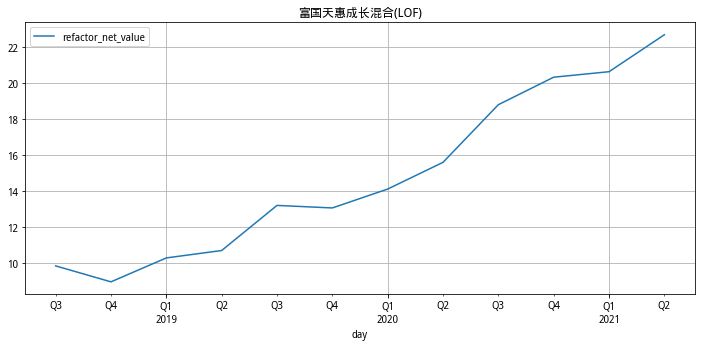

In [11]:
df_value.plot(figsize=(12,5),title=fund_name)
pl.grid()

### 获取季报持仓

In [15]:
types = ('第一季度','第二季度','第三季度','第四季度')
df_stock = finance.run_query(query(finance.FUND_PORTFOLIO_STOCK)
                             .filter(finance.FUND_PORTFOLIO_STOCK.code==code)
                             .filter(finance.FUND_PORTFOLIO_STOCK.rank <= 10)
                             .filter(finance.FUND_PORTFOLIO_STOCK.report_type.in_(types))
                             .filter(finance.FUND_PORTFOLIO_STOCK.period_start >= start_date)
                             .filter(finance.FUND_PORTFOLIO_STOCK.period_start <= end_date)
                            )
df_stock.head()

,id,code,period_start,period_end,pub_date,report_type_id,report_type,rank,symbol,name,shares,market_cap,proportion
0,14265190,161005,2018-10-01,2018-12-31,2019-01-19,403004,第四季度,1,300285,国瓷材料,20263800.0,3.377975e+08,5.96
1,14265191,161005,2018-10-01,2018-12-31,2019-01-19,403004,第四季度,2,601318,中国平安,4350550.0,2.440659e+08,4.31
2,14265192,161005,2018-10-01,2018-12-31,2019-01-19,403004,第四季度,3,300572,安车检测,5620000.0,2.430330e+08,4.29
3,14265193,161005,2018-10-01,2018-12-31,2019-01-19,403004,第四季度,4,600176,中国巨石,23501811.0,2.272625e+08,4.01
4,14265194,161005,2018-10-01,2018-12-31,2019-01-19,403004,第四季度,5,300226,上海钢联,4900100.0,2.231016e+08,3.94


In [20]:
 df_stock['report_type'].value_counts()

第四季度    30
第一季度    30
第三季度    20
第二季度    20
Name: report_type, dtype: int64

### 获取行业

获取申万一级行业

In [22]:
def my_industry(x):
    code = normalize_code([x['symbol']])[0]
    industry = get_industry(security=[code], date=x['period_end'])
    if 'sw_l1' in industry[code]:
        return industry[code]['sw_l1']['industry_name']
    return '其它'

In [25]:
df_stock['industry'] = df_stock.apply(my_industry, axis=1)
df_stock[['symbol','name','industry']].head()

,symbol,name,industry
0,300285,国瓷材料,化工I
1,601318,中国平安,非银金融I
2,300572,安车检测,机械设备I
3,600176,中国巨石,化工I
4,300226,上海钢联,传媒I


### 获取每个行业的仓位

In [28]:
g=df_stock[['period_end','industry','proportion']].groupby(['period_end','industry'])
df_industry = g['proportion'].sum().unstack().fillna(0)
df_industry.tail(10)

industry,交通运输I,传媒I,化工I,医药生物I,商业贸易I,家用电器I,建筑材料I,机械设备I,电子I,计算机I,银行I,非银金融I,食品饮料I
period_end,,,,,,,,,,,,,
2018-12-31,0.00,3.94,12.78,3.09,0.00,0.00,0.00,4.29,0.00,2.79,2.80,4.31,3.55
2019-03-31,0.00,5.87,7.17,7.26,3.48,0.00,0.00,6.28,0.00,0.00,2.99,6.48,7.71
2019-06-30,0.00,4.72,7.22,4.95,3.25,3.33,0.00,5.13,0.00,0.00,2.75,6.55,9.79
2019-09-30,0.00,3.84,7.03,4.37,2.87,3.28,0.00,5.20,2.87,0.00,0.00,6.26,9.71
2019-12-31,0.00,3.10,7.15,0.00,3.03,3.95,0.00,3.92,2.82,0.00,2.95,5.15,8.74
2020-03-31,0.00,3.45,5.77,3.49,0.00,3.41,3.13,3.06,0.00,0.00,0.00,3.98,11.07
2020-06-30,3.26,0.00,6.77,3.44,0.00,3.39,0.00,4.23,0.00,3.56,0.00,3.25,11.41
2020-09-30,4.37,0.00,4.31,6.24,0.00,2.98,0.00,0.00,2.67,2.70,2.73,0.00,11.34
2020-12-31,3.74,0.00,3.53,5.26,0.00,2.81,0.00,0.00,2.71,0.00,3.23,3.69,11.58


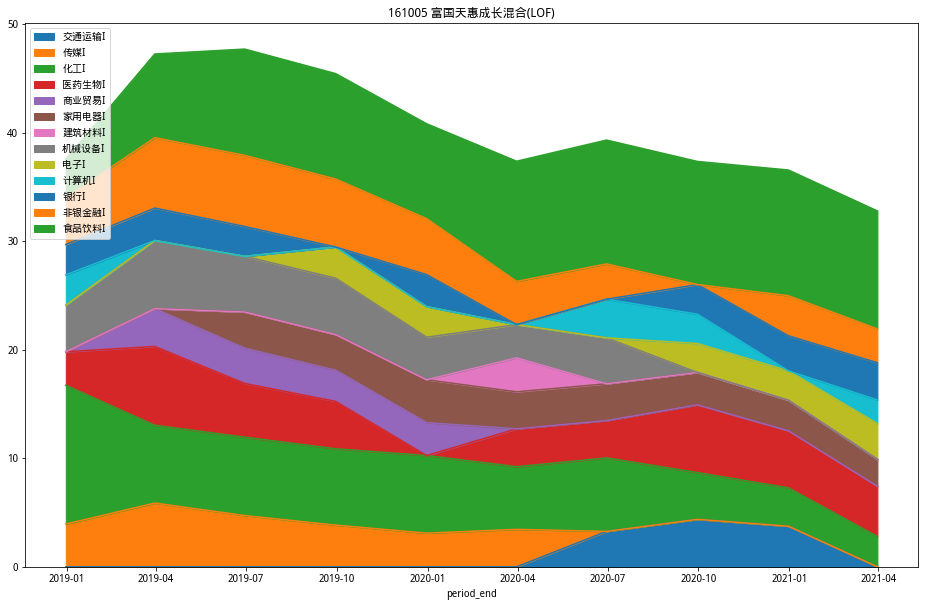

In [30]:
df_industry.plot.area(figsize=(16,10),title=code + ' ' +fund_name)
pl.legend(loc='upper left')

### 行业市值

In [36]:
g=df_stock[['period_end','industry','market_cap']].groupby(['period_end','industry'])
df_industry_cap = g['market_cap'].sum().unstack().fillna(0)
df_industry_cap.tail(10)

industry,交通运输I,传媒I,化工I,医药生物I,商业贸易I,家用电器I,建筑材料I,机械设备I,电子I,计算机I,银行I,非银金融I,食品饮料I
period_end,,,,,,,,,,,,,
2018-12-31,0.000000e+00,2.231016e+08,7.243238e+08,1.750000e+08,0.000000e+00,0.000000e+00,0.0,243033000.0,0.000000e+00,1.582519e+08,1.589089e+08,2.440659e+08,2.013451e+08
2019-03-31,0.000000e+00,4.194814e+08,5.122399e+08,5.185331e+08,2.487099e+08,0.000000e+00,0.0,448630000.0,0.000000e+00,0.000000e+00,2.136983e+08,4.626028e+08,5.511207e+08
2019-06-30,0.000000e+00,3.897925e+08,5.958484e+08,4.088127e+08,2.679360e+08,2.750000e+08,0.0,423168000.0,0.000000e+00,0.000000e+00,2.266740e+08,5.405210e+08,8.088350e+08
2019-09-30,0.000000e+00,3.471668e+08,6.361200e+08,3.947413e+08,2.595834e+08,2.968140e+08,0.0,469800000.0,2.596977e+08,0.000000e+00,0.000000e+00,5.657600e+08,8.782600e+08
2019-12-31,0.000000e+00,3.345400e+08,7.709613e+08,0.000000e+00,3.269105e+08,4.262973e+08,0.0,423104000.0,3.040080e+08,0.000000e+00,3.181554e+08,5.554900e+08,9.429360e+08
2020-03-31,0.000000e+00,3.745500e+08,6.276000e+08,3.795697e+08,0.000000e+00,3.706200e+08,340300000.0,333018000.0,0.000000e+00,0.000000e+00,0.000000e+00,4.326030e+08,1.202523e+09
2020-06-30,4.649760e+08,0.000000e+00,9.650880e+08,4.908012e+08,0.000000e+00,4.836735e+08,0.0,602885609.2,0.000000e+00,5.080880e+08,0.000000e+00,4.641000e+08,1.627655e+09
2020-09-30,1.055677e+09,0.000000e+00,1.040200e+09,1.506386e+09,0.000000e+00,7.195500e+08,0.0,0.0,6.455759e+08,6.510600e+08,6.579761e+08,0.000000e+00,2.737706e+09
2020-12-31,1.146990e+09,0.000000e+00,1.082640e+09,1.613054e+09,0.000000e+00,8.609660e+08,0.0,0.0,8.306259e+08,0.000000e+00,9.895200e+08,1.130740e+09,3.552824e+09


In [63]:
df_industry_volatility = (df_industry_cap - df_industry_cap.shift(1)) / df_industry_cap.shift(1)
df_industry_volatility.replace([np.inf, -np.inf], np.nan, inplace=True)
df_industry_volatility.fillna(0, inplace=True)
df_industry_volatility.head(10)

industry,交通运输I,传媒I,化工I,医药生物I,商业贸易I,家用电器I,建筑材料I,机械设备I,电子I,计算机I,银行I,非银金融I,食品饮料I
period_end,,,,,,,,,,,,,
2018-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-03-31,0.000000,0.880226,-0.292803,1.963047,0.000000,0.000000,0.0,0.845963,0.000000,-1.000000,0.344785,0.895401,1.737195
2019-06-30,0.000000,-0.070775,0.163221,-0.211598,0.077303,0.000000,0.0,-0.056755,0.000000,0.000000,0.060720,0.168434,0.467619
2019-09-30,0.000000,-0.109355,0.067587,-0.034420,-0.031174,0.079324,0.0,0.110197,0.000000,0.000000,-1.000000,0.046694,0.085833
2019-12-31,0.000000,-0.036371,0.211975,-1.000000,0.259366,0.436244,0.0,-0.099395,0.170623,0.000000,0.000000,-0.018153,0.073641
2020-03-31,0.000000,0.119597,-0.185951,0.000000,-1.000000,-0.130607,0.0,-0.212917,-1.000000,0.000000,-1.000000,-0.221223,0.275297
2020-06-30,0.000000,-1.000000,0.537744,0.293046,0.000000,0.305039,-1.0,0.810369,0.000000,0.000000,0.000000,0.072808,0.353534
2020-09-30,1.270390,0.000000,0.077829,2.069239,0.000000,0.487677,0.0,-1.000000,0.000000,0.281392,0.000000,-1.000000,0.681994
2020-12-31,0.086497,0.000000,0.040800,0.070811,0.000000,0.196534,0.0,0.000000,0.286643,-1.000000,0.503884,0.000000,0.297738


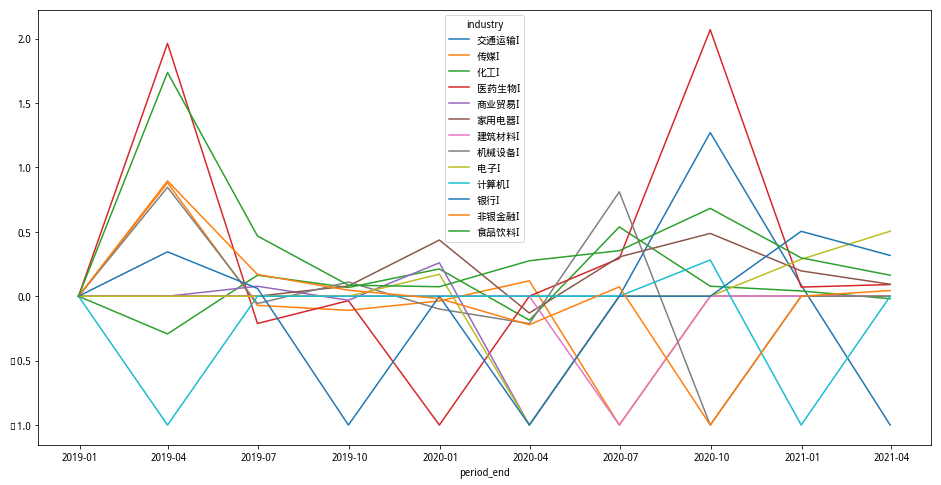

In [64]:
df_industry_volatility.plot(figsize=(16,8))

### 获取行业指数数据

In [238]:
df_industry_index = finance.run_query(query(finance.SW1_DAILY_PRICE)
                             .filter(extract('day',finance.SW1_DAILY_PRICE.date) < 10)                             
                             .filter(extract('month',finance.SW1_DAILY_PRICE.date).in_([3,6,9,12]))
                             .filter(finance.SW1_DAILY_PRICE.date >= start_date)
                             .filter(finance.SW1_DAILY_PRICE.date <= end_date)
                            )
df_industry_index.head(10)

,id,date,code,name,open,high,low,close,volume,money,change_pct
0,147150,2018-09-03,801130,纺织服装,1992.19,1992.68,1963.18,1986.16,2.912261e+08,2.204801e+09,-0.45
1,147151,2018-09-03,801720,建筑装饰,2286.07,2286.32,2246.88,2273.64,8.412562e+08,5.872076e+09,-0.90
2,147152,2018-09-03,801150,医药生物,7162.82,7176.56,7068.59,7176.56,1.313417e+09,2.172961e+10,-0.15
3,147153,2018-09-03,801110,家用电器,5499.83,5500.40,5434.61,5489.87,4.242305e+08,5.672827e+09,-0.59
4,147154,2018-09-03,801080,电子元器件,2513.11,2513.24,2465.80,2503.74,1.989326e+09,2.211844e+10,-0.64
5,147155,2018-09-03,801760,传媒,634.01,636.75,627.06,635.98,1.436911e+09,1.049590e+10,-0.05
6,147156,2018-09-03,801740,国防军工,987.00,1006.09,979.30,1005.62,4.718935e+08,6.055260e+09,1.87
7,147157,2018-09-03,801210,餐饮旅游,5302.68,5323.42,5183.15,5294.58,1.060398e+08,1.581359e+09,-0.60
8,147158,2018-09-03,801040,钢铁,2684.84,2686.08,2645.29,2676.38,7.527096e+08,3.748972e+09,-0.43
9,147159,2018-09-03,801170,交通运输,2217.31,2217.31,2179.30,2197.74,8.189202e+08,6.425277e+09,-1.33


In [239]:
g=df_industry_index.reset_index()[['date','name','money']].groupby(['date','name'])
df_industry_index = g['money'].sum().unstack().fillna(0)
df_industry_index.tail(10)

name,交通运输,传媒,公用事业,农林牧渔,化工,医药生物,商业贸易,国防军工,家用电器,建筑材料,建筑装饰,房地产,有色金属,机械设备,汽车,电子元器件,电气设备,纺织服装,综合,计算机,轻工制造,通信,采掘,钢铁,银行,非银金融,食品饮料,餐饮旅游
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-05,1.364408e+10,2.234072e+10,2.710281e+10,2.385271e+10,6.982776e+10,6.471573e+10,8.207380e+09,2.318852e+10,1.195095e+10,1.630636e+10,1.415390e+10,1.765292e+10,7.326994e+10,4.525034e+10,3.316901e+10,7.700373e+10,5.982977e+10,5.431529e+09,3.092053e+09,3.383117e+10,1.564945e+10,1.090423e+10,1.800095e+10,1.992931e+10,3.039874e+10,5.420725e+10,5.165776e+10,7.143861e+09
2021-03-08,1.722958e+10,2.644849e+10,3.248287e+10,2.540993e+10,7.877943e+10,8.001515e+10,9.119922e+09,2.800074e+10,1.519669e+10,1.557401e+10,1.635351e+10,1.708554e+10,6.844618e+10,4.947120e+10,4.077805e+10,8.846604e+10,7.186289e+10,5.941657e+09,3.532351e+09,3.733330e+10,1.682633e+10,1.365163e+10,1.787201e+10,1.901489e+10,3.019669e+10,5.297381e+10,6.068929e+10,1.018667e+10
2021-03-09,2.240020e+10,2.475360e+10,3.368296e+10,2.270349e+10,7.891417e+10,8.230834e+10,8.390981e+09,2.316922e+10,1.595344e+10,1.552020e+10,1.846963e+10,1.707497e+10,7.163933e+10,5.106153e+10,3.974273e+10,8.825322e+10,6.763527e+10,6.433357e+09,3.216553e+09,3.754595e+10,1.741044e+10,1.312417e+10,1.746380e+10,2.320099e+10,3.184192e+10,5.061790e+10,6.419713e+10,1.223557e+10
2021-06-01,2.108917e+10,2.645779e+10,3.148407e+10,2.235745e+10,8.942641e+10,1.111672e+11,1.212447e+10,2.510614e+10,1.472213e+10,1.320929e+10,1.114375e+10,1.963050e+10,5.440204e+10,4.695063e+10,4.939632e+10,9.513492e+10,6.111880e+10,1.226448e+10,3.634753e+09,5.128299e+10,2.221334e+10,1.460164e+10,2.209889e+10,1.262437e+10,1.767358e+10,5.482926e+10,6.866785e+10,5.654748e+09
2021-06-02,2.489443e+10,2.640182e+10,3.286471e+10,2.517093e+10,8.673860e+10,1.150927e+11,1.078625e+10,2.169377e+10,1.265505e+10,1.243210e+10,1.131804e+10,2.008171e+10,5.185879e+10,4.578848e+10,4.524172e+10,8.307295e+10,5.677657e+10,1.460641e+10,4.026322e+09,4.614833e+10,2.107625e+10,1.339707e+10,2.588535e+10,8.867242e+09,1.762976e+10,4.849577e+10,6.815949e+10,5.103265e+09
2021-06-03,2.560528e+10,2.110696e+10,2.992550e+10,2.185605e+10,8.085097e+10,9.309785e+10,1.277605e+10,1.784147e+10,1.267029e+10,1.027847e+10,1.183016e+10,2.010726e+10,5.301715e+10,4.321984e+10,3.953190e+10,7.338243e+10,5.767693e+10,1.445201e+10,3.447133e+09,4.615545e+10,1.796692e+10,1.923894e+10,2.660788e+10,1.403244e+10,1.747134e+10,4.766945e+10,7.257253e+10,4.675328e+09
2021-06-04,1.969133e+10,2.061724e+10,2.319619e+10,2.003979e+10,7.958483e+10,8.343274e+10,1.029419e+10,1.903151e+10,1.089958e+10,9.854952e+09,1.039281e+10,2.094985e+10,5.561545e+10,4.105617e+10,3.810687e+10,9.159073e+10,6.443304e+10,1.147747e+10,3.566499e+09,4.153827e+10,1.754074e+10,1.569973e+10,2.091544e+10,9.198280e+09,2.016106e+10,6.034379e+10,7.005038e+10,5.175825e+09
2021-06-07,1.976389e+10,2.134977e+10,2.103006e+10,2.189242e+10,8.072614e+10,8.410655e+10,1.054383e+10,2.147935e+10,1.198140e+10,9.725092e+09,1.035485e+10,1.870077e+10,4.945424e+10,3.891926e+10,3.586444e+10,1.079498e+11,6.306944e+10,1.000596e+10,4.949862e+09,4.995001e+10,1.750356e+10,1.713037e+10,1.928922e+10,7.383391e+09,1.446187e+10,4.424300e+10,8.534134e+10,4.843541e+09
2021-06-08,1.845175e+10,2.215873e+10,2.439998e+10,1.972441e+10,8.005453e+10,9.328883e+10,1.021921e+10,2.784766e+10,1.225438e+10,8.551858e+09,1.006967e+10,1.736935e+10,4.858367e+10,3.715933e+10,4.468463e+10,9.937365e+10,5.863351e+10,1.055622e+10,7.500053e+09,6.245516e+10,1.673061e+10,1.723676e+10,1.702438e+10,8.381104e+09,1.702413e+10,4.758272e+10,9.493469e+10,4.973608e+09


In [240]:
df_industry_index.reset_index(inplace=True)
df_industry_index['date'] = pd.to_datetime(df_industry_index['date'])
df_industry_index.set_index('date', inplace=True )
df_industry_index = df_industry_index.resample('3M').last()
df_industry_index

name,交通运输,传媒,公用事业,农林牧渔,化工,医药生物,商业贸易,国防军工,家用电器,建筑材料,建筑装饰,房地产,有色金属,机械设备,汽车,电子元器件,电气设备,纺织服装,综合,计算机,轻工制造,通信,采掘,钢铁,银行,非银金融,食品饮料,餐饮旅游
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-30,5.759293e+09,1.147371e+10,1.019019e+10,4.996196e+09,1.636905e+10,2.152045e+10,3.335334e+09,7.726147e+09,5.786666e+09,3.832938e+09,6.775546e+09,6.334876e+09,1.065413e+10,1.418226e+10,6.928727e+09,2.565777e+10,9.969071e+09,2.337238e+09,1.369542e+09,3.646059e+10,4.334678e+09,1.550533e+10,7.411956e+09,3.706212e+09,6.325416e+09,9.613280e+09,1.123441e+10,2.109080e+09
2018-12-31,4.758336e+09,1.234509e+10,7.546647e+09,6.432152e+09,1.455736e+10,3.400224e+10,3.251397e+09,3.200357e+09,4.578754e+09,4.918128e+09,7.999738e+09,7.931202e+09,1.009968e+10,1.323439e+10,8.957448e+09,1.903307e+10,1.037384e+10,2.777091e+09,2.339180e+09,1.337752e+10,4.689131e+09,1.345393e+10,3.438517e+09,2.612441e+09,4.398678e+09,1.108594e+10,7.957321e+09,1.425615e+09
2019-03-31,2.715982e+10,6.097658e+10,3.611327e+10,3.123445e+10,5.823203e+10,6.472407e+10,1.795555e+10,1.999821e+10,2.418208e+10,1.485352e+10,3.060290e+10,3.544947e+10,5.316988e+10,5.564024e+10,3.213745e+10,1.335978e+11,4.677957e+10,9.783538e+09,9.563546e+09,1.185053e+11,2.175720e+10,6.335468e+10,1.869795e+10,1.315075e+10,3.444258e+10,1.216832e+11,2.449592e+10,4.989622e+09
2019-06-30,8.412994e+09,1.466626e+10,9.185206e+09,2.370159e+10,2.164785e+10,2.568191e+10,4.607400e+09,6.797290e+09,5.938207e+09,3.898340e+09,7.217428e+09,1.107868e+10,2.968587e+10,1.677862e+10,1.068528e+10,4.214731e+10,1.364830e+10,3.123846e+09,3.863237e+09,2.825014e+10,6.731711e+09,3.075294e+10,7.404341e+09,2.779037e+09,9.077244e+09,2.191715e+10,1.528269e+10,1.549163e+09
2019-09-30,1.116258e+10,3.258115e+10,1.244582e+10,1.993265e+10,4.058023e+10,4.460109e+10,7.677539e+09,2.126082e+10,1.014703e+10,6.536146e+09,9.828331e+09,1.492645e+10,2.733782e+10,3.378178e+10,1.736137e+10,1.158316e+11,2.549375e+10,3.592243e+09,2.528815e+09,8.236708e+10,9.348988e+09,5.342884e+10,8.259123e+09,2.733221e+09,1.701511e+10,4.986101e+10,2.415133e+10,2.756133e+09
2019-12-31,6.743674e+09,2.388446e+10,6.158614e+09,1.144916e+10,2.346536e+10,3.300960e+10,5.782621e+09,5.866122e+09,7.592961e+09,7.958161e+09,7.599872e+09,1.520894e+10,1.660136e+10,2.199932e+10,1.266567e+10,9.080867e+10,1.454364e+10,3.189403e+09,3.050895e+09,5.204981e+10,8.325290e+09,1.469488e+10,5.396277e+09,5.237591e+09,9.076381e+09,2.040354e+10,1.550197e+10,1.715566e+09
2020-03-31,2.102308e+10,4.484460e+10,1.836400e+10,3.557470e+10,8.047543e+10,9.729545e+10,1.191291e+10,2.124963e+10,2.152972e+10,1.687247e+10,2.185122e+10,2.354133e+10,3.827829e+10,5.181019e+10,2.886649e+10,1.416991e+11,5.562655e+10,2.540290e+10,7.737029e+09,8.780628e+10,1.794383e+10,5.527930e+10,1.087306e+10,6.882657e+09,2.159202e+10,7.095672e+10,2.786299e+10,3.833294e+09
2020-06-30,1.386589e+10,4.812338e+10,8.586785e+09,1.576171e+10,3.865943e+10,7.127328e+10,1.318459e+10,1.061223e+10,1.033404e+10,8.520768e+09,7.546801e+09,1.682474e+10,2.092880e+10,2.604267e+10,2.294634e+10,9.043235e+10,2.385276e+10,5.120899e+09,2.757015e+09,3.940881e+10,1.053437e+10,1.514078e+10,5.344242e+09,2.705584e+09,8.390705e+09,2.705595e+10,2.906484e+10,4.743973e+09
2020-09-30,2.461735e+10,4.938169e+10,2.718262e+10,2.645800e+10,6.858774e+10,9.249664e+10,1.069809e+10,3.806708e+10,1.753092e+10,1.304481e+10,2.075592e+10,1.904926e+10,2.841513e+10,6.806856e+10,3.125321e+10,1.173078e+11,6.979461e+10,8.516008e+09,3.560803e+09,9.130137e+10,1.611605e+10,2.750921e+10,1.294265e+10,1.027789e+10,1.500340e+10,5.259827e+10,3.574841e+10,7.476772e+09


In [245]:
df_vol = get_vol(df_industry_index)
df_vol.head()

name,交通运输,传媒,公用事业,农林牧渔,化工,医药生物,商业贸易,国防军工,家用电器,建筑材料,建筑装饰,房地产,有色金属,机械设备,汽车,电子元器件,电气设备,纺织服装,综合,计算机,轻工制造,通信,采掘,钢铁,银行,非银金融,食品饮料,餐饮旅游
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-12-31,-0.173799,0.075946,-0.259421,0.287410,-0.110677,0.579996,-0.025166,-0.585776,-0.208740,0.283122,0.180678,0.251990,-0.052041,-0.066835,0.292798,-0.258195,0.040602,0.188193,0.708002,-0.633097,0.081771,-0.132303,-0.536085,-0.295118,-0.304603,0.153190,-0.291701,-0.324058
2019-03-31,4.707840,3.939339,3.785339,3.855987,3.000178,0.903524,4.522411,5.248743,4.281367,2.020157,2.825488,3.469622,4.264510,3.204216,2.587791,6.019244,3.509379,2.522945,3.088419,7.858543,3.639920,3.709010,4.437794,4.033893,6.830212,9.976347,2.078413,2.499978
2019-06-30,-0.690241,-0.759477,-0.745656,-0.241172,-0.628248,-0.603209,-0.743400,-0.660105,-0.754438,-0.737548,-0.764159,-0.687480,-0.441679,-0.698445,-0.667513,-0.684521,-0.708242,-0.680704,-0.596046,-0.761613,-0.690598,-0.514591,-0.604002,-0.788678,-0.736453,-0.819883,-0.376113,-0.689523
2019-09-30,0.326826,1.221503,0.354985,-0.159016,0.874562,0.736673,0.666350,2.127838,0.708769,0.676648,0.361750,0.347312,-0.079096,1.013382,0.624793,1.748257,0.867906,0.149942,-0.345416,1.915635,0.388798,0.737357,0.115443,-0.016486,0.874480,1.274977,0.580306,0.779111


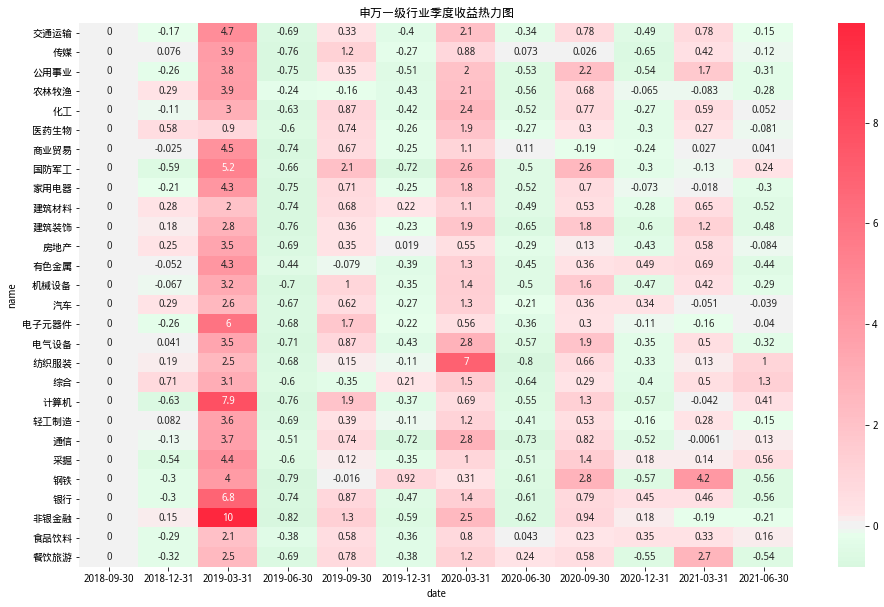

In [251]:
df_vol.index = df_vol.index.astype('str') # 默认时间格式在热力图里显示太长
show_heap(df_vol, '申万一级行业季度收益热力图')

### 获取指数

In [66]:
s = get_security_info("000300.XSHG")

In [67]:
s.display_name

'沪深300'

In [68]:
df = get_index_weights(index_id="000300.XSHG", date="2018-05-09")
df.head()

,date,weight,display_name
code,,,
002044.XSHE,2018-04-27,0.271,美年健康
000413.XSHE,2018-04-27,0.275,东旭光电
000415.XSHE,2018-04-27,0.099,渤海租赁
002426.XSHE,2018-04-27,0.086,胜利精密
600909.XSHG,2018-04-27,0.067,华安证券


In [121]:
df = get_bars('000300.XSHG', 12*3, fields=['date','close'],unit='1M',df=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True )
df.head()

,close
date,
2018-07-31,3517.66
2018-08-31,3334.50
2018-09-28,3438.86
2018-10-31,3153.82
2018-11-30,3172.69


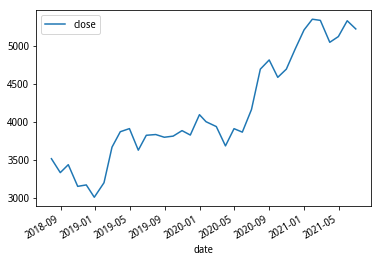

In [122]:
df.plot()

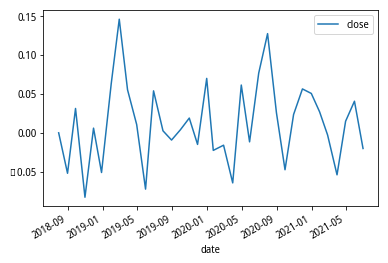

In [128]:
((df - df.shift(1)) / df.shift(1)).fillna(0).plot()

In [129]:
df = df[df.index.month.isin([6,12])].resample('6M').last()
df.head()

,close
date,
2018-12-31,3010.65
2019-06-30,3825.59
2019-12-31,4096.58
2020-06-30,4163.96
2020-12-31,5211.29


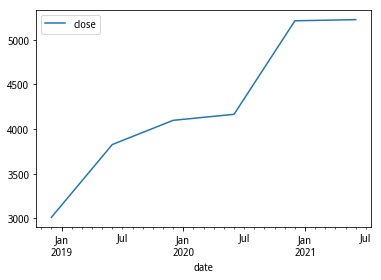

In [130]:
df.plot()

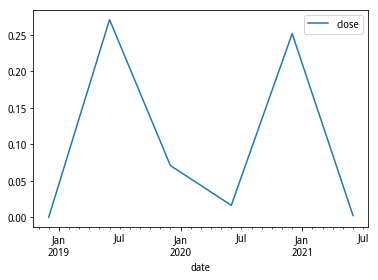

In [131]:
((df - df.shift(1)) / df.shift(1)).fillna(0).plot()

### 基准

In [95]:
df = finance.run_query(query(finance.FUND_MAIN_INFO).filter(finance.FUND_MAIN_INFO.main_code==index_code).limit(1))
fund_name = df['name'][0]
fund_mode = df['operate_mode'][0]
fund_type = df['underlying_asset_type'][0]
print(fund_name, fund_mode, fund_type)

兴全沪深300指数(LOF) LOF 股票型


In [96]:
df_index = finance.run_query(query(finance.FUND_NET_VALUE.day,
                                   finance.FUND_NET_VALUE.refactor_net_value)
                             .filter(finance.FUND_NET_VALUE.code==index_code)
                             .filter(extract('day',finance.FUND_NET_VALUE.day) < 10)                             
                             .filter(extract('month',finance.FUND_NET_VALUE.day).in_([3,6,9,12]))
                             .filter(finance.FUND_NET_VALUE.day >= start_date)
                             .filter(finance.FUND_NET_VALUE.day <= end_date)
                            )
df_index['day'] = pd.to_datetime(df_index['day'])
df_index.set_index('day', inplace=True )
df_index = df_value.resample('3M').last()
df_index.head(10)

,refactor_net_value
day,
2018-09-30,9.850577
2018-12-31,8.964744
2019-03-31,10.293210
2019-06-30,10.704146
2019-09-30,13.208252
2019-12-31,13.067877
2020-03-31,14.116726
2020-06-30,15.599553
2020-09-30,18.800025


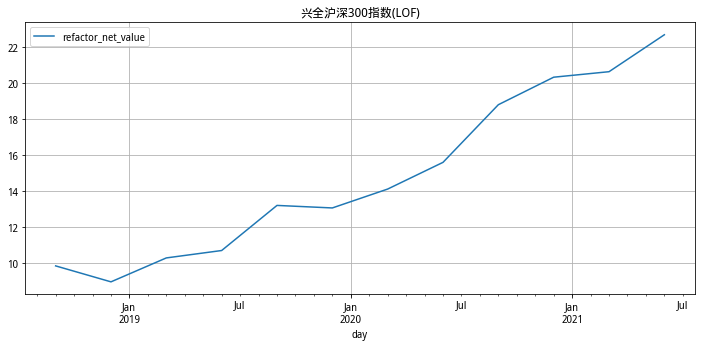

In [97]:
df_index.plot(figsize=(12,5),title=fund_name)
pl.grid()

In [98]:
types = ('第一季度','第二季度','第三季度','第四季度')
df_index_stock = finance.run_query(query(finance.FUND_PORTFOLIO_STOCK)
                             .filter(finance.FUND_PORTFOLIO_STOCK.code==index_code)
                             .filter(finance.FUND_PORTFOLIO_STOCK.report_type.in_(types))
                             .filter(finance.FUND_PORTFOLIO_STOCK.period_start >= start_date)
                             .filter(finance.FUND_PORTFOLIO_STOCK.period_start <= end_date)
                            )
df_index_stock.head()

,id,code,period_start,period_end,pub_date,report_type_id,report_type,rank,symbol,name,shares,market_cap,proportion
0,14266680,163407,2018-10-01,2018-12-31,2019-01-22,403004,第四季度,1,601318,中国平安,2718800.0,1.525247e+08,7.53
1,14266681,163407,2018-10-01,2018-12-31,2019-01-22,403004,第四季度,2,601601,中国太保,3668800.0,1.043040e+08,5.15
2,14266682,163407,2018-10-01,2018-12-31,2019-01-22,403004,第四季度,3,600036,招商银行,2398838.0,6.045072e+07,2.99
3,14266683,163407,2018-10-01,2018-12-31,2019-01-22,403004,第四季度,4,000895,双汇发展,2518800.0,5.941849e+07,2.93
4,14266684,163407,2018-10-01,2018-12-31,2019-01-22,403004,第四季度,5,600519,贵州茅台,90893.0,5.362778e+07,2.65


In [99]:
df_index_stock['industry'] = df_index_stock.apply(my_industry, axis=1)
df_index_stock[['symbol','name','industry']].head()

,symbol,name,industry
0,601318,中国平安,非银金融I
1,601601,中国太保,非银金融I
2,600036,招商银行,银行I
3,000895,双汇发展,食品饮料I
4,600519,贵州茅台,食品饮料I


In [100]:
df_index_stock['industry'].value_counts()

非银金融I    28
食品饮料I    20
银行I      20
医药生物I    17
农林牧渔I    10
公用事业I     9
休闲服务I     8
采掘I       7
家用电器I     7
机械设备I     5
汽车I       5
电子I       5
传媒I       4
计算机I      2
国防军工I     1
交通运输I     1
轻工制造I     1
Name: industry, dtype: int64

In [101]:
g=df_index_stock[['period_end','industry','proportion']].groupby(['period_end','industry'])
df_index_industry = g['proportion'].sum().unstack().fillna(0)
df_index_industry.tail(10)

industry,交通运输I,休闲服务I,传媒I,公用事业I,农林牧渔I,医药生物I,国防军工I,家用电器I,机械设备I,汽车I,电子I,计算机I,轻工制造I,采掘I,银行I,非银金融I,食品饮料I
period_end,,,,,,,,,,,,,,,,,
2018-12-31,0.00,2.52,0.00,0.00,1.03,0.41,0.00,3.60,0.00,2.31,0.00,0.00,0.22,0.25,5.19,15.01,5.58
2019-03-31,0.00,2.21,0.31,0.00,1.01,0.40,0.00,4.39,0.00,2.18,0.00,0.00,0.00,0.21,4.98,16.44,5.20
2019-06-30,0.00,2.38,0.00,0.62,0.88,0.35,0.00,2.23,0.00,2.33,0.00,0.00,0.00,0.39,7.67,17.19,3.25
2019-09-30,0.00,2.37,0.00,0.55,1.20,2.86,0.00,0.00,0.00,2.39,0.00,0.00,0.00,0.32,8.18,16.04,3.67
2019-12-31,0.00,0.00,0.00,0.44,0.78,3.40,0.00,2.34,0.00,2.46,0.00,0.00,0.00,0.14,5.56,14.56,5.86
2020-03-31,0.11,0.00,2.93,0.41,0.85,3.20,0.00,0.00,0.78,0.00,2.90,2.37,0.00,0.00,2.46,11.97,6.37
2020-06-30,0.00,4.34,3.78,0.80,1.12,4.74,0.00,0.00,0.93,0.00,4.76,3.21,0.00,0.00,2.56,8.86,7.95
2020-09-30,0.00,5.96,2.87,0.64,1.09,4.33,0.00,0.00,0.65,0.00,4.47,0.00,0.00,0.00,2.40,11.86,8.02
2020-12-31,0.00,6.86,0.00,0.59,0.92,3.39,0.00,0.00,0.70,0.00,4.05,0.00,0.00,0.00,3.28,11.99,12.36


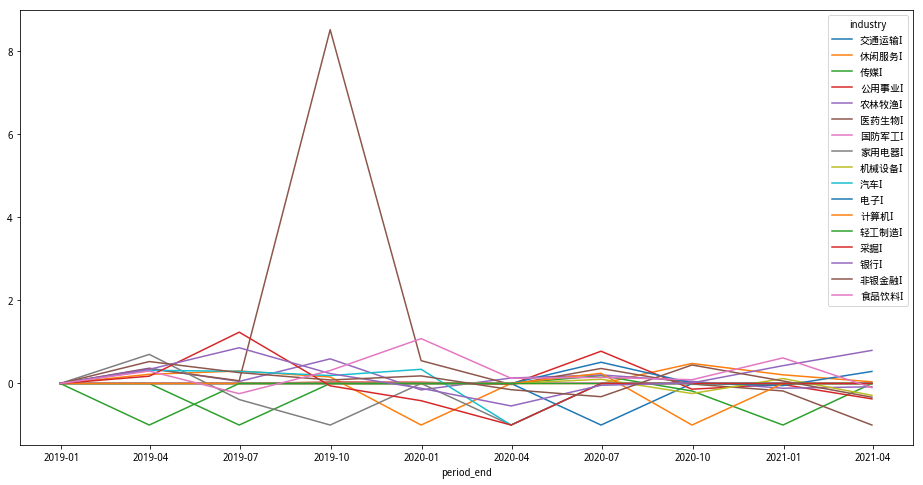

In [104]:
g=df_index_stock[['period_end','industry','market_cap']].groupby(['period_end','industry'])
df_index_industry_cap = g['market_cap'].sum().unstack().fillna(0)
df_index_industry_vol = (df_index_industry_cap - df_index_industry_cap.shift(1)) / df_index_industry_cap.shift(1)
df_index_industry_vol.replace([np.inf, -np.inf], np.nan, inplace=True)
df_index_industry_vol.fillna(0, inplace=True)
df_index_industry_vol.plot(figsize=(16,8))

In [126]:
df_index_industry_vol.shape, df_industry_volatility.shape

((10, 17), (10, 13))

In [135]:
common_columns = df_industry_volatility.columns.intersection(df_index_industry_vol.columns)
common_columns

Index(['交通运输I', '传媒I', '医药生物I', '家用电器I', '机械设备I', '电子I', '计算机I', '银行I',
       '非银金融I', '食品饮料I'],
      dtype='object', name='industry')

In [137]:
df = df_industry_volatility[common_columns] - df_index_industry_vol[common_columns]
df

industry,交通运输I,传媒I,医药生物I,家用电器I,机械设备I,电子I,计算机I,银行I,非银金融I,食品饮料I
period_end,,,,,,,,,,
2018-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-03-31,0.000000,0.880226,1.606525,-0.700578,0.845963,0.000000,-1.000000,0.004405,0.367385,1.437590
2019-06-30,0.000000,0.929225,-0.277221,0.386527,-0.056755,0.000000,0.000000,-0.800009,-0.093516,0.712115
2019-09-30,0.000000,-0.109355,-8.551600,1.079324,0.110197,0.000000,0.000000,-1.239096,-0.037723,-0.225845
2019-12-31,0.000000,-0.036371,-1.549866,0.436244,-0.099395,0.170623,0.000000,0.115269,-0.201232,-1.007247
2020-03-31,0.000000,0.119597,0.024440,0.869393,-0.212917,-1.000000,0.000000,-0.459155,-0.072331,0.150074
2020-06-30,1.000000,-1.188974,-0.068394,0.305039,0.707939,-0.511324,-0.246349,0.043469,0.391251,0.205415
2020-09-30,1.270390,0.180255,2.081937,0.487677,-0.758361,-0.011801,1.281392,-0.014169,-1.445610,0.591786
2020-12-31,0.086497,1.000000,0.250455,0.196534,-0.118929,0.336085,-1.000000,0.075178,-0.060824,-0.318708


Text(0.5, 1.0, '行业超额收益')

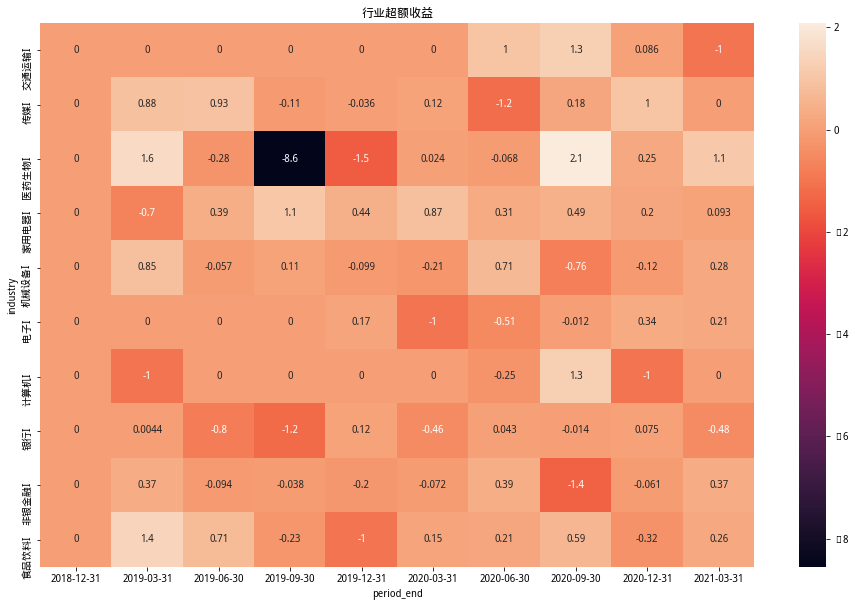

In [139]:
plt.figure(figsize=(16,10))
sns.heatmap(data=df.fillna(0).T, annot=True)
plt.title('行业超额收益') 

Text(0.5, 1.0, '各行业收益')

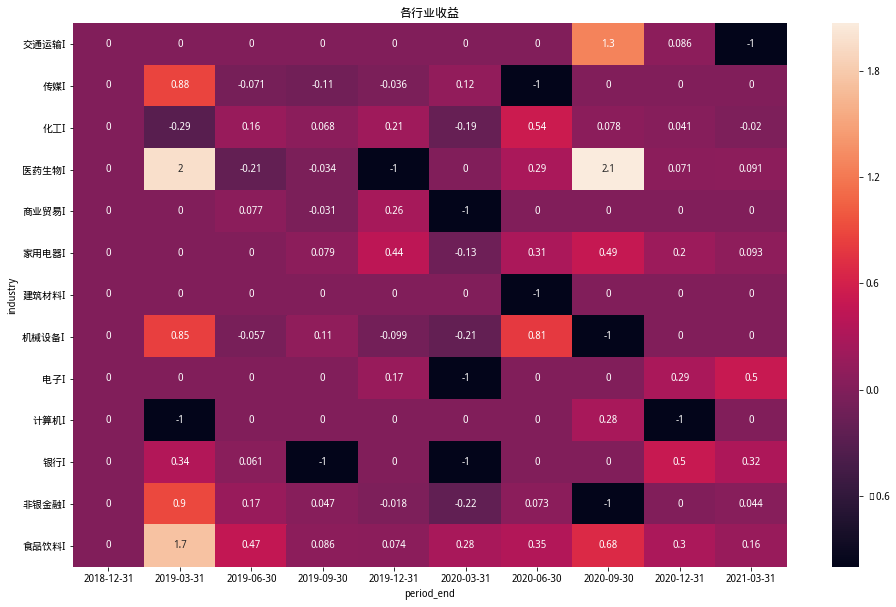

In [154]:
plt.figure(figsize=(16,10))
sns.heatmap(data=df_industry_volatility.fillna(0).T, annot=True)
plt.title('各行业收益') 

In [166]:
def show_heap(data, title):
    fig, ax = plt.subplots(figsize=(16,10))
    rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)
    sns.heatmap(data.T, cmap=rdgn, center=0.00, annot=True, ax=ax)
    plt.title(title) 
    plt.show()

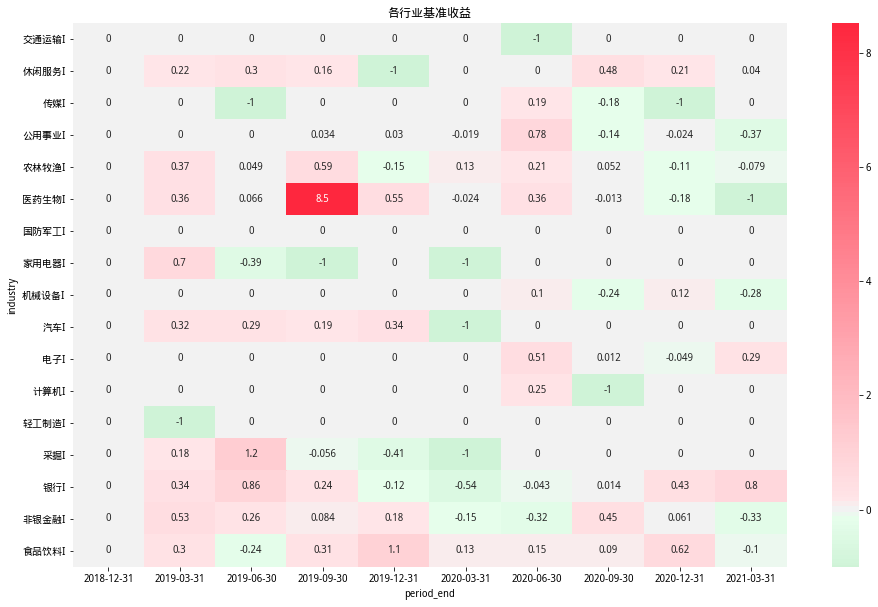

In [167]:
show_heap(df_index_industry_vol, '各行业基准收益')

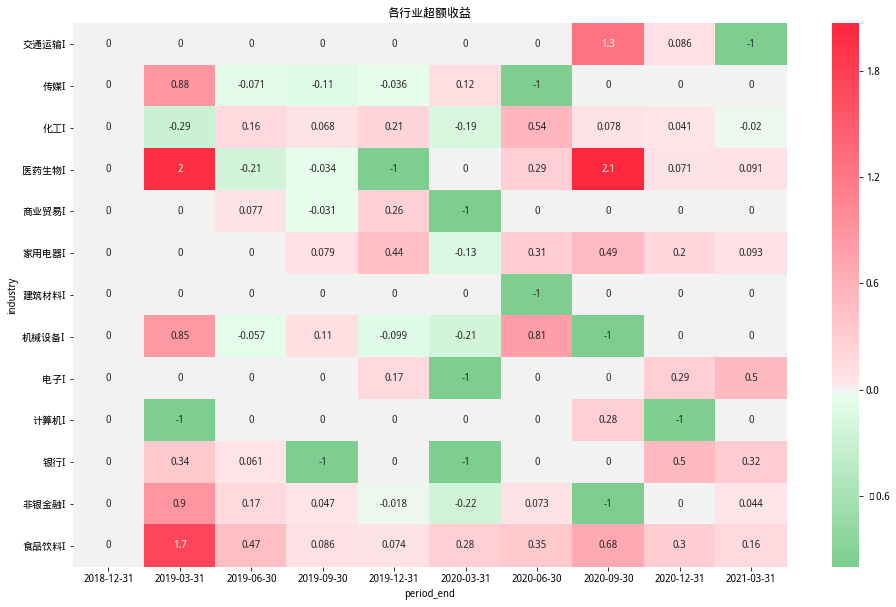

In [168]:
show_heap(df_industry_volatility, '各行业超额收益')

In [253]:
df_vol.shape,df_industry_volatility.shape

((12, 28), (10, 13))

In [257]:
df_industry_volatility

industry,交通运输I,传媒I,化工I,医药生物I,商业贸易I,家用电器I,建筑材料I,机械设备I,电子I,计算机I,银行I,非银金融I,食品饮料I
period_end,,,,,,,,,,,,,
2018-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-03-31,0.000000,0.880226,-0.292803,1.963047,0.000000,0.000000,0.0,0.845963,0.000000,-1.000000,0.344785,0.895401,1.737195
2019-06-30,0.000000,-0.070775,0.163221,-0.211598,0.077303,0.000000,0.0,-0.056755,0.000000,0.000000,0.060720,0.168434,0.467619
2019-09-30,0.000000,-0.109355,0.067587,-0.034420,-0.031174,0.079324,0.0,0.110197,0.000000,0.000000,-1.000000,0.046694,0.085833
2019-12-31,0.000000,-0.036371,0.211975,-1.000000,0.259366,0.436244,0.0,-0.099395,0.170623,0.000000,0.000000,-0.018153,0.073641
2020-03-31,0.000000,0.119597,-0.185951,0.000000,-1.000000,-0.130607,0.0,-0.212917,-1.000000,0.000000,-1.000000,-0.221223,0.275297
2020-06-30,0.000000,-1.000000,0.537744,0.293046,0.000000,0.305039,-1.0,0.810369,0.000000,0.000000,0.000000,0.072808,0.353534
2020-09-30,1.270390,0.000000,0.077829,2.069239,0.000000,0.487677,0.0,-1.000000,0.000000,0.281392,0.000000,-1.000000,0.681994
2020-12-31,0.086497,0.000000,0.040800,0.070811,0.000000,0.196534,0.0,0.000000,0.286643,-1.000000,0.503884,0.000000,0.297738


In [259]:
df_vol.columns = [i+'I' for i in df_vol.columns]

In [276]:
df_vol.columns.name = 'industry'

In [277]:
common_columns = df_vol.columns.intersection(df_industry_volatility.columns)

In [287]:
df_vol.index.name = 'period_end'
df_industry_volatility.index = df_industry_volatility.index.astype('str') # 默认时间格式在热力图里显示太长

In [288]:
df_industry_volatility.index, df_vol.index

(Index(['2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
        '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31', '2021-03-31'],
       dtype='object', name='period_end'),
 Index(['2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30',
        '2019-12-31', '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
        '2021-03-31', '2021-06-30'],
       dtype='object', name='period_end'))

In [298]:
df  = df_industry_volatility[common_columns] = df_vol[common_columns]

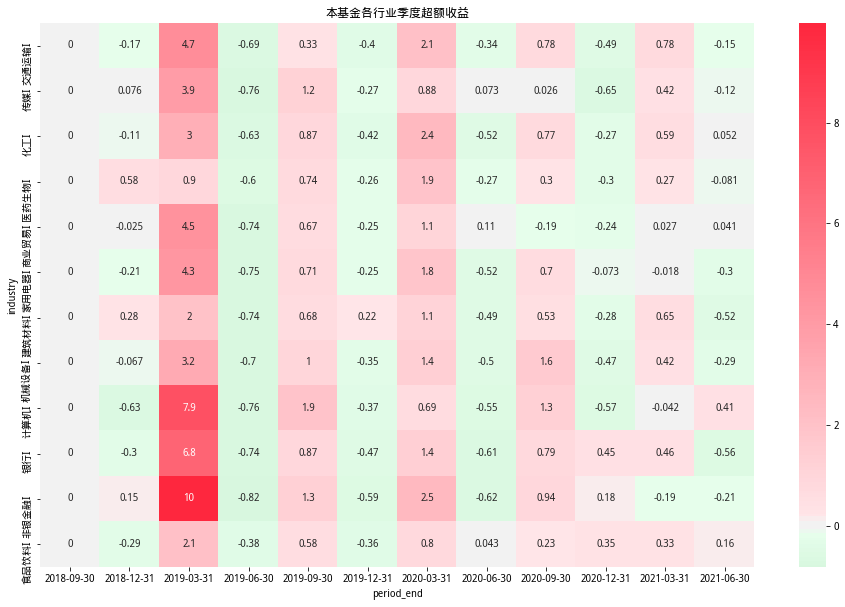

In [299]:
show_heap(df, '本基金各行业季度超额收益')

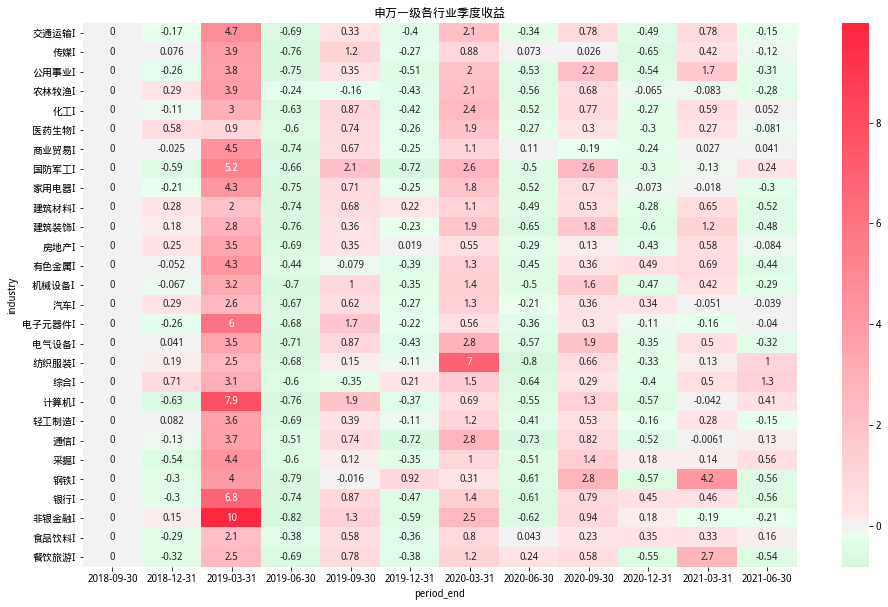

In [300]:
show_heap(df_vol, '申万一级各行业季度收益')

In [302]:
df_vol['计算机I'],df_industry_volatility['计算机I']

(period_end
 2018-09-30    0.000000
 2018-12-31   -0.633097
 2019-03-31    7.858543
 2019-06-30   -0.761613
 2019-09-30    1.915635
 2019-12-31   -0.368075
 2020-03-31    0.686966
 2020-06-30   -0.551185
 2020-09-30    1.316775
 2020-12-31   -0.570842
 2021-03-31   -0.041774
 2021-06-30    0.410485
 Name: 计算机I, dtype: float64, period_end
 2018-12-31   -0.633097
 2019-03-31    7.858543
 2019-06-30   -0.761613
 2019-09-30    1.915635
 2019-12-31   -0.368075
 2020-03-31    0.686966
 2020-06-30   -0.551185
 2020-09-30    1.316775
 2020-12-31   -0.570842
 2021-03-31   -0.041774
 Name: 计算机I, dtype: float64)

### test

In [7]:
df = get_index_weights(index_id="000001.XSHG", date="2018-05-09")
df.head()

,date,weight,display_name
code,,,
603648.XSHG,2018-04-27,0.023,畅联股份
603139.XSHG,2018-04-27,0.007,康惠制药
603138.XSHG,2018-04-27,0.015,海量数据
603136.XSHG,2018-04-27,0.009,天目湖
603131.XSHG,2018-04-27,0.011,上海沪工


In [8]:
df.reset_index(inplace=True)
df.head()

,code,date,weight,display_name
0,603648.XSHG,2018-04-27,0.023,畅联股份
1,603139.XSHG,2018-04-27,0.007,康惠制药
2,603138.XSHG,2018-04-27,0.015,海量数据
3,603136.XSHG,2018-04-27,0.009,天目湖
4,603131.XSHG,2018-04-27,0.011,上海沪工


In [9]:
df['industry'] = df.apply(lambda x: my_industry(x, 'code', 'date'), axis=1)
df.head()

,code,date,weight,display_name,industry
0,603648.XSHG,2018-04-27,0.023,畅联股份,交通运输I
1,603139.XSHG,2018-04-27,0.007,康惠制药,医药生物I
2,603138.XSHG,2018-04-27,0.015,海量数据,计算机I
3,603136.XSHG,2018-04-27,0.009,天目湖,休闲服务I
4,603131.XSHG,2018-04-27,0.011,上海沪工,机械设备I


In [10]:
g=df[['date','industry','weight']].groupby(['date','industry'])
df = g['weight'].sum().unstack().fillna(0)
df.tail(10)

industry,交通运输I,休闲服务I,传媒I,公用事业I,其它,农林牧渔I,化工I,医药生物I,商业贸易I,国防军工I,家用电器I,建筑材料I,建筑装饰I,房地产I,有色金属I,机械设备I,汽车I,电子I,电气设备I,纺织服装I,综合I,计算机I,轻工制造I,通信I,采掘I,钢铁I,银行I,非银金融I,食品饮料I
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-27,5.094,0.639,1.686,4.594,0.285,0.96,5.464,5.053,1.727,1.55,0.685,0.81,4.078,3.611,3.334,2.788,3.752,1.854,2.304,0.972,0.699,2.24,1.222,1.552,6.904,1.619,20.254,9.197,5.085


In [33]:
def last_n_month(n):
    import calendar
    import datetime 
    now = datetime.datetime.now()
    for i in range(1, n+1):
        day = now - datetime.timedelta(days=i*30) 
        yield '%s-%02d-%02d' % (day.year, day.month, calendar.monthrange(day.year, day.month)[1])

In [34]:
list(last_n_month(13))

['2021-06-30',
 '2021-05-31',
 '2021-04-30',
 '2021-03-31',
 '2021-02-28',
 '2021-01-31',
 '2020-12-31',
 '2020-11-30',
 '2020-10-31',
 '2020-09-30',
 '2020-08-31',
 '2020-07-31',
 '2020-06-30']